# Validate classification problems

Objectives
- Cross Validation
- Classification Metrics: Precision, Recall, F1, ROC AUC
- Confusion Matrix
- Imbalanced Classes

Reading
- [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)
- [ROC curves and Area Under the Curve explained](https://www.dataschool.io/roc-curves-and-auc-explained/)

In [ ]:
%matplotlib inline
import warnings
from IPython.display import display
import category_encoders as ce
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions #----NEW!
import pandas as pd
from sklearn.exceptions import DataConversionWarning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict #-NEW!
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report #-----NEW!
from sklearn.metrics import confusion_matrix #----------NEW!
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve #-----------------NEW!
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


warnings.filterwarnings(action='ignore', category=DataConversionWarning)

* [`category_encoders`](https://github.com/scikit-learn-contrib/categorical-encoding)
* [`mlxtend`](http://rasbt.github.io/mlxtend/) to plot decision regions

# Cross Validation, Classification Metrics & Confusion Matrix

# Example: Bank Marketing dataset

In [2]:
# Load data
X_train = pd.read_csv('datasets/bank-marketing/train_features.csv').drop(columns='id')
X_test  = pd.read_csv('datasets/bank-marketing/test_features.csv').drop(columns='id')
y_train = pd.read_csv('datasets/bank-marketing/train_labels.csv')['y']
sample_submission = pd.read_csv('datasets/bank-marketing/sample_submission.csv')

# Make pipeline
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    StandardScaler(), 
    LogisticRegression(solver='lbfgs', max_iter=1000)
)

#### scikit-learn documentation
- [sklearn.linear_model.LogisticRegression.predict_proba](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba)
- [sklearn.metrics.classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
- [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
- [sklearn.model_selection.cross_val_predict](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html)

In [3]:
y_pred_proba = cross_val_predict(pipeline, X_train, y_train, cv=3, n_jobs=-1, 
                                 method='predict_proba')[:, 1]

#### Change the threshold and re-run this cell

In [0]:
threshold = 0.5 # affects precision and accuracy
y_pred = y_pred_proba >= threshold

print(classification_report(y_train, y_pred))

pd.DataFrame(confusion_matrix(y_train, y_pred), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

              precision    recall  f1-score   support

           0       0.91      0.98      0.95     27411
           1       0.65      0.23      0.34      3480

   micro avg       0.90      0.90      0.90     30891
   macro avg       0.78      0.61      0.64     30891
weighted avg       0.88      0.90      0.88     30891



,Predicted Negative,Predicted Positive
Actual Negative,26990,421
Actual Positive,2690,790


In [7]:
true_negative  = 26990
false_positive =   421
false_negative =  2690
true_positive  =   790

accuracy = ((true_negative + true_positive) / 
            (true_negative + false_positive + false_negative + true_positive))

print('Accuracy:', accuracy)

actual_negative = true_negative + false_positive
actual_positive = false_negative + true_positive

predicted_negative = true_negative + false_negative
predicted_positive = true_positive + false_positive

precision = true_positive / predicted_positive
print('Precision:', precision)

recall = true_positive / actual_positive
print('Recall:', recall)

f1 = 2 * precision * recall / (precision + recall)
print('f1:', f1)

Accuracy: 0.899291055647276
Precision: 0.652353426919901
Recall: 0.22701149425287356
f1: 0.3368151780004264


Trading off precision and recall is a case-by-case desicion. 

#### ROC Curve
- [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
- [sklearn.metrics.roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

is a commonly used graph that summarizes the performance of a classifier over all possible thresholds. It is generated by plotting the True Positive Rate (y-axis) against the False Positive Rate (x-axis) as you vary the threshold for assigning observations to a given class. The area under the curve is a summary of the model's ability to rank false positives vs true positives. In the best case, the area under the curve is `1.0`. In the worst case (chance), it's `0.5`, a straight diagonal line from (0, 0) to (1, 1).

Area under the Receiver Operating Characteristic curve: 0.7868823584541318


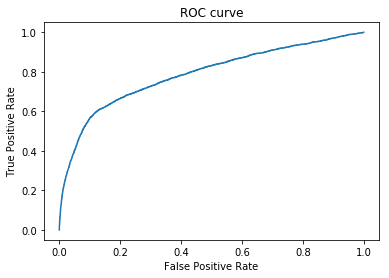

In [8]:
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('Area under the Receiver Operating Characteristic curve:', 
      roc_auc_score(y_train, y_pred_proba))

# Imbalanced Classes — with synthetic data

The next code cell does five things:

#### 1. Generate data

We use scikit-learn's [make_classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) function to generate fake data for a binary classification problem, based on several parameters, including:
- Number of samples
- Weights, meaning "the proportions of samples assigned to each class."
- Class separation: "Larger values spread out the clusters/classes and make the classification task easier."

(We are generating fake data so it is easy to visualize.)

#### 2. Split data

We split the data three ways, into train, validation, and test sets. (For this toy example, it's not really necessary to do a three-way split. A two-way split, or even no split, would be ok. But I'm trying to demonstrate good habits, even in toy examples, to avoid confusion.)

#### 3. Fit model

We use scikit-learn to fit a [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) on the training data.

We use this model parameter:

> **class_weight : _dict or ‘balanced’, default: None_**

> Weights associated with classes in the form `{class_label: weight}`. If not given, all classes are supposed to have weight one.

> The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as `n_samples / (n_classes * np.bincount(y))`.


#### 4. Evaluate model

We use our Logistic Regression model, which was fit on the training data, to generate predictions for the validation data.

Then we print [scikit-learn's Classification Report](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report), with many metrics, and also the accuracy score. We are comparing the correct labels to the Logistic Regression's predicted labels, for the validation set. 

#### 5. Visualize decision function

Based on these examples
- https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/combine/plot_comparison_combine.html
- http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/#example-1-decision-regions-in-2d

In [14]:
def train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, 
    random_state=None, shuffle=True):
        
    assert train_size + val_size + test_size == 1
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=shuffle)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(train_size+val_size), 
        random_state=random_state, shuffle=shuffle)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

             precision    recall  f1-score   support

          0       0.98      1.00      0.99        96
          1       1.00      0.50      0.67         4

avg / total       0.98      0.98      0.98       100

accuracy 0.98


,Predicted Negative,Predicted Positive
Actual Negative,96,0
Actual Positive,2,2


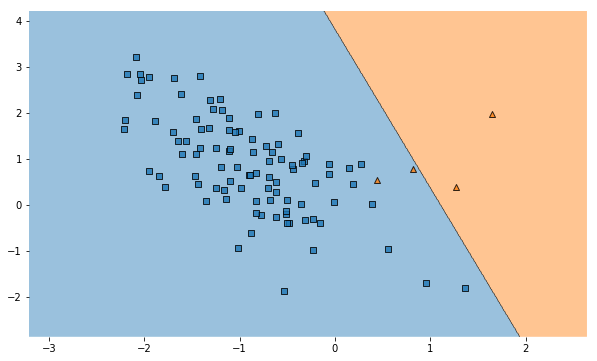

In [21]:
#1. Generate data

# Try re-running the cell with different values for these parameters
n_samples = 1000
weights = (0.95, 0.05)
class_sep = 0.8

X, y = make_classification(n_samples=n_samples, n_features=2, n_informative=2, 
                           n_redundant=0, n_repeated=0, n_classes=2, 
                           n_clusters_per_class=1, weights=weights, 
                           class_sep=class_sep, random_state=0)


# 2. Split data

# Uses our custom train_validation_test_split function
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, random_state=1)


# 3. Fit model

# Try re-running the cell with different values for this parameter
class_weight = None

model = LogisticRegression(solver='lbfgs', class_weight=class_weight)
model.fit(X_train, y_train)


# 4. Evaluate model

y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))
print('accuracy', accuracy_score(y_val, y_pred))
display(pd.DataFrame(
    confusion_matrix(y_val, y_pred), 
    columns=['Predicted Negative', 'Predicted Positive'], 
    index=['Actual Negative', 'Actual Positive']))


# 5. Visualize decision regions

plt.figure(figsize=(10, 6))
plot_decision_regions(X_val, y_val, model, legend=0);

Try re-running the cell above with different values for these four parameters:
- `n_samples`
- `weights`
- `class_sep`
- `class_balance`

For example, with a 50% / 50% class distribution:
```
n_samples = 1000
weights = (0.50, 0.50)
class_sep = 0.8
class_balance = None
```

With a 95% / 5% class distribution:
```
n_samples = 1000
weights = (0.95, 0.05)
class_sep = 0.8
class_balance = None
```

With the same 95% / 5% class distribution, but changing the Logistic Regression's `class_balance` parameter to `'balanced'` (instead of its default `None`)
```
n_samples = 1000
weights = (0.95, 0.05)
class_sep = 0.8
class_balance = 'balanced'
```

With the same 95% / 5% class distribution, but with different values for `class_balance`:
- `{0: 1, 1: 1}` _(equivalent to `None`)_
- `{0: 1, 1: 2}`
- `{0: 1, 1: 10}` _(roughly equivalent to `'balanced'` for this dataset)_
- `{0: 1, 1: 100}`
- `{0: 1, 1: 10000}`

How do the evaluation metrics and decision region plots change?

## What you can do about imbalanced classes?

[Learning from Imbalanced Classes](https://www.svds.com/tbt-learning-imbalanced-classes/) gives "a rough outline of useful approaches" : 

- Do nothing. Sometimes you get lucky and nothing needs to be done. You can train on the so-called natural (or stratified) distribution and sometimes it works without need for modification.
- Balance the training set in some way:
  - Oversample the minority class.
  - Undersample the majority class.
  - Synthesize new minority classes.
- Throw away minority examples and switch to an anomaly detection framework.
- At the algorithm level, or after it:
  - Adjust the class weight (misclassification costs).
  - Adjust the decision threshold.
  - Modify an existing algorithm to be more sensitive to rare classes.
- Construct an entirely new algorithm to perform well on imbalanced data.


#### We demonstrated two of these options: 

- "Adjust the class weight (misclassification costs)" — many scikit-learn classifiers have a `class_balance` parameter
- "Adjust the decision threshold" — you can lean more about this in a great blog post, [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415).

#### Another option to be aware of:
- The [imbalance-learn](https://github.com/scikit-learn-contrib/imbalanced-learn) library can be used to "oversample the minority class, undersample the majority class, or synthesize new minority classes."

# ASSIGNMENT

#### Bank Marketing
- Make another submission on Kaggle.
- Try "Cross-Validation + Independent Test Set" instead of "Train/Validate/Test Split."
- Explore and visualize your data. 
- Wrangle [bad data](https://github.com/Quartz/bad-data-guide), outliers, and missing values.
- Try engineering more features. You can transform, bin, and combine features. 
- Try using fewer features. You can look at multicollinearity. 
- Try the `class_weight` parameter.

#### Imbalanced Classes demo with synthetic data
- Play around with the demo. Change parameter values.
- Be able to calculate precision, recall, F1, and accuracy "by hand", given a confusion matrix and access to Wikipedia.

# STRETCH
- Read the blog post, [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415). You can replicate the code as-is,  ["the hard way"](https://docs.google.com/document/d/1ubOw9B3Hfip27hF2ZFnW3a3z9xAgrUDRReOEo-FHCVs/edit). Or you can apply it to the Bank Marketing dataset.
- Try the [imbalance-learn](https://github.com/scikit-learn-contrib/imbalanced-learn) library.
- Try other [scikit-learn classifiers](https://scikit-learn.org/stable/supervised_learning.html), beyond Logistic Regression.